Exact Diag Ham:  [[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Ham real:  SparsePauliOp(['IZ', 'ZI', 'XY', 'YX'],
              coeffs=[-0.5+0.j,  0.5+0.j, -0. +0.j, -0. +0.j])
Ham imag:  SparsePauliOp(['XX', 'YY', 'II', 'IZ', 'ZI'],
              coeffs=[-0.25+0.j,  0.25+0.j,  0.5 +0.j, -0.  +0.j, -0.  +0.j])
Initil State :  Statevector([ 1.0000000e+00+7.34788079e-16j,
             -2.4492936e-16-2.99951957e-32j,
             -3.6739404e-16-8.99855870e-32j,
             -1.2246468e-16-5.47382213e-48j],
            dims=(2, 2))
Exact Initial :  [[ 1.0000000e+00+7.34788079e-16j -3.6739404e-16-8.99855870e-32j]
 [-2.4492936e-16-2.99951957e-32j -1.2246468e-16-5.47382213e-48j]]
Operator:  [[0.        +0.j 0.        +0.j]
 [0.70710678+0.j 0.        +0.j]]
Operator:  [[0.        +0.j 0.70710678+0.j]
 [0.        +0.j 0.        +0.j]]
Operator:  [[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Operator:  [[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
Initial expectation value of number operator: (-1.224646799147353e-16+8.998558695

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


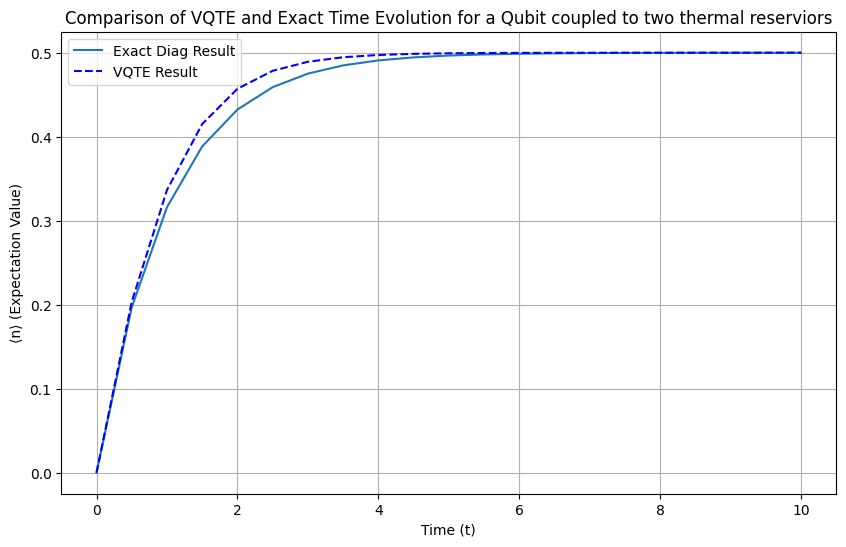

0.499999341599155


In [1]:
# Initialize the simulation parameters
from imports import *
from globalMethods import *
from vqteMethods import *
from exactDiagMethods import *
# from fidelity_main import *

def main():
        # Initialize the simulation parameters
        #run_multiple_layers(2,10, 0.05)
        
        gamma_L = 1
        gamma_R = 0

        eps = 1.0

        mu_L= 1.0
        mu_R= 1.0

        # Temperature of Reserviors
        T_L = 10
        T_R= 10

        time = 10
        dt = 0.5
        nt = int(time/dt)

        beta_L=1/T_L
        beta_R=1/T_R
        F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
        F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)


        # Generate Hamiltonians
        exact_diag_ham = build_exact_diag_hamiltonian(eps)
        ham_real, ham_imag = hamiltonian_generation(eps, gamma_L, gamma_R, F_R,F_L)
        print("Exact Diag Ham: ", exact_diag_ham)
        print("Ham real: ", ham_real)
        print("Ham imag: ", ham_imag)


        # Generate initial states
        vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
        print("Initil State : " , vqte_init_state)
        print("Exact Initial : ", exact_diag_init_state)

        # Perform exact diagonalization
        exact_diag_results, time_points = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state, exact_diag_ham)
    
        # Perform vqte simulation
        vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)

        #Output results
        output_results(vqte_results, exact_diag_results, time, nt, time_points)
        print(vqte_results[-1])
main()